Compute hyperfine energies and wavefunctions for selected rovibrational states of $\text{H}_2\text{S}$.

The hyperfine interaction includes spin-rotation coupling.

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

import itertools

import h5py
import hdfdict
import matplotlib.pyplot as plt
import numpy as np
from py3nj import wigner3j
from rovib.hyperfine_xy2 import dipole_xy2, spin_me_xy2, spinrot_xy2
from rovib.symtop import symtop_on_grid_split_angles
from scipy import constants, stats
from scipy.interpolate import RegularGridInterpolator
from scipy.sparse import csr_matrix
from scipy.spatial.transform import Rotation


KHZ_TO_INVCM = 1.0 / constants.value("speed of light in vacuum") * 10

DEBYE_TO_AU = (
    1e-21
    / constants.value("speed of light in vacuum")
    / constants.value("elementary charge")
    / constants.value("Bohr radius")
)

# conversion to inverse centimeters for a quantity 'field times dipole',
# where field is in Volts/meter and dipole is in Debye
DEBYE_X_VM_TO_INVCM = (
    constants.value("atomic unit of electric dipole mom.")
    / (constants.value("Planck constant") * constants.value("speed of light in vacuum"))
    / 1e2
    * DEBYE_TO_AU
)

# spins of Y1 and Y2 in XY2-type molecule
SPIN1 = 0.5
SPIN2 = 0.5

# size of vibrational basis set (used in the naming of various matrix element and energy files)
PMAX = 24

Load rovibrational energies and matrix elements of spin-rotation tensors, electric dipole moment, and valence coordinates from files. 

The matrix elements are precomputed for selected states using `h2s_cart_me.py`.
For example, files `h2s_enr_1000_j40_j60_pmax24.h5` and `h2s_me_100_j...h5` contain energies and matrix elemetns for 1000 lowest rovibrational states for each $J=40..60$, calculated using vibrational basis truncated at $P_\text{max}=24$. 

In [2]:
# min_j = 40
# max_j = 60
min_j = 56
max_j = 60
tol = 1e-12

print(f"Read energies and quanta for J = {min_j}..{max_j}")

with h5py.File(f"h2s_enr_1000_j40_j60_pmax{PMAX}.h5", "r") as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)
    coefs = hdfdict.load(h5.require_group("coefficients"), False)
    vind = hdfdict.load(h5.require_group("vib-indices"), False)
    rind = hdfdict.load(h5.require_group("rot-indices"), False)

rovib_enr = {
    int(j): {sym: enr_sym for sym, enr_sym in enr_j.items()} for j, enr_j in enr.items()
}

rovib_coefs = {
    int(j): {sym: coefs_sym for sym, coefs_sym in coefs_j.items()}
    for j, coefs_j in coefs.items()
}

rovib_vind = {
    int(j): {sym: vind_sym for sym, vind_sym in vind_j.items()}
    for j, vind_j in vind.items()
}

rovib_rind = {
    int(j): {sym: rind_sym for sym, rind_sym in rind_j.items()}
    for j, rind_j in rind.items()
}

rovib_qua = {
    int(j): {
        sym: np.array(
            [[i] + elem[0].decode("utf-8").split(",") for i, elem in enumerate(qua_sym)]
        )
        for sym, qua_sym in qua_j.items()
    }
    for j, qua_j in qua.items()
}

print(f"Read spin-rotation and dipole matrix elements for J = {min_j}..{max_j}")

rovib_sr1 = {}
rovib_sr2 = {}
rovib_dipole = {}
rovib_coord = {}

for j1 in range(min_j, max_j + 1):
    for j2 in range(min_j, max_j + 1):
        try:
            filename = f"h2s_me_1000_j{j1}_j{j2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(j1, j2)}, |dJ| = {abs(j1-j2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2 = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dipole = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dipole = {}
                try:
                    coord = hdfdict.load(h5.require_group("coordinate"), False)
                except ValueError:
                    coord = {}

                rovib_sr1[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in sr1.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_sr2[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in sr2.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_dipole[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in dipole.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_coord[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in coord.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

        except FileNotFoundError:
            pass

Read energies and quanta for J = 56..60
Read spin-rotation and dipole matrix elements for J = 56..60
read (J1, J2) = (56, 56), |dJ| = 0, from file h2s_me_1000_j56_j56.h5
read (J1, J2) = (56, 57), |dJ| = 1, from file h2s_me_1000_j56_j57.h5
read (J1, J2) = (56, 58), |dJ| = 2, from file h2s_me_1000_j56_j58.h5
read (J1, J2) = (57, 56), |dJ| = 1, from file h2s_me_1000_j57_j56.h5
read (J1, J2) = (57, 57), |dJ| = 0, from file h2s_me_1000_j57_j57.h5
read (J1, J2) = (57, 58), |dJ| = 1, from file h2s_me_1000_j57_j58.h5
read (J1, J2) = (57, 59), |dJ| = 2, from file h2s_me_1000_j57_j59.h5
read (J1, J2) = (58, 56), |dJ| = 2, from file h2s_me_1000_j58_j56.h5
read (J1, J2) = (58, 57), |dJ| = 1, from file h2s_me_1000_j58_j57.h5
read (J1, J2) = (58, 58), |dJ| = 0, from file h2s_me_1000_j58_j58.h5
read (J1, J2) = (58, 59), |dJ| = 1, from file h2s_me_1000_j58_j59.h5
read (J1, J2) = (58, 60), |dJ| = 2, from file h2s_me_1000_j58_j60.h5
read (J1, J2) = (59, 57), |dJ| = 2, from file h2s_me_1000_j59_j57.h5
re

Calculate hyperfine states for selected $F$ (quantum number of the total spin-rotational angular momentum)

In [3]:
# min_f = 40.0
# max_f = 60.0
min_f = 58.0
max_f = 58.0

hyper_qua = {}
hyper_qua_block = {}
hyper_enr = {}
hyper_vec = {}

for f in np.linspace(min_f, max_f, int(max_f - min_f) + 1):

    print(f"solve for f = {f}")

    ham_sr, hyper_qua[f], hyper_qua_block[f] = spinrot_xy2(
        f,
        rovib_enr,
        rovib_qua,
        rovib_sr1,
        rovib_sr2,
        spin_states=((0, "B2"), (1, "A1")),
        spins=(SPIN1, SPIN2),
    )

    hyper_enr[f] = {}
    hyper_vec[f] = {}

    for sym, qua_sym in hyper_qua_block[f].items():
        h0 = np.diag(
            np.concatenate(
                np.array([rovib_enr[int(j)][rov_sym] for (j, rov_sym, *_) in qua_sym]),
                axis=-1,
            )
        )

        h = h0 + ham_sr[sym]
        enr, vec = np.linalg.eigh(h)
        hyper_enr[f][sym] = enr
        hyper_vec[f][sym] = vec

        # for e, v in zip(enr, vec.T):
        #     ind = np.argmax(v**2)
        #     print(
        #         f"F = {f}, sym = {sym}, enr = {e}, shift (kHz) = {(e - h0[ind, ind]) / KHZ_TO_INVCM}, "
        #         + f"leading quanta = {hyper_qua[f][sym][ind]}, |c|**2 = {np.abs(v[ind])**2}"
        #     )

solve for f = 58.0


Read indices of rotational cluster states in the vibrational ground state.

In [4]:
min_j = 40
max_j = 60
cluster_state_ind = {}
with open(f"h2s_cluster_states_id_pmax{PMAX}.txt", "r", encoding="utf-8") as fl:
    for line in fl:
        w = line.split()
        j = [int(w[0 + i * 12]) for i in range(4)]
        id = [int(w[1 + i * 12]) for i in range(4)]
        sym = [w[3 + i * 12] for i in range(4)]
        assert all(j[0] == elem for elem in j), f"Not all J quanta are equal: {j}"
        j_ = j[0]

        if j_ >= min_j and j_ <= max_j:
            cluster_state_ind[j_] = {}
            for sym_, id_ in zip(sym, id):
                try:
                    cluster_state_ind[j_][sym_].append(id_)
                except KeyError:
                    cluster_state_ind[j_][sym_] = [id_]
            cluster_state_ind[j_] = dict(sorted(cluster_state_ind[j_].items()))
            print(f"J = {j_}, cluster-state IDs: {cluster_state_ind[j_]}")

J = 40, cluster-state IDs: {'A1': [106], 'A2': [97], 'B1': [97], 'B2': [104]}
J = 41, cluster-state IDs: {'A1': [101], 'A2': [120], 'B1': [120], 'B2': [103]}
J = 42, cluster-state IDs: {'A1': [130], 'A2': [118], 'B1': [117], 'B2': [129]}
J = 43, cluster-state IDs: {'A1': [126], 'A2': [145], 'B1': [146], 'B2': [127]}
J = 44, cluster-state IDs: {'A1': [157], 'A2': [145], 'B1': [144], 'B2': [156]}
J = 45, cluster-state IDs: {'A1': [153], 'A2': [173], 'B1': [174], 'B2': [154]}
J = 46, cluster-state IDs: {'A1': [193], 'A2': [170], 'B1': [169], 'B2': [192]}
J = 47, cluster-state IDs: {'A1': [188], 'A2': [208], 'B1': [210], 'B2': [189]}
J = 48, cluster-state IDs: {'A1': [230], 'A2': [205], 'B1': [205], 'B2': [228]}
J = 49, cluster-state IDs: {'A1': [224], 'A2': [248], 'B1': [249], 'B2': [225]}
J = 50, cluster-state IDs: {'A1': [280], 'A2': [242], 'B1': [242], 'B2': [277]}
J = 51, cluster-state IDs: {'A1': [267], 'A2': [299], 'B1': [299], 'B2': [270]}
J = 52, cluster-state IDs: {'A1': [327], '

Identify cluster states among the hyperfine states. List the hyperfine states with the largest mixing of rovibrational states; note that the lowest-energy states with the highest degree of mixing correspond to cluster states in the vibrational ground state. States with high mixing and higher energies represent cluster states in vibrationally excited states.

In [5]:
hyper_state_ind = {
    f: {sym: [] for sym in val.keys()} for f, val in hyper_qua.items()
}

for f, v_f in hyper_vec.items():
    for sym, v_sym in v_f.items():
        enr = hyper_enr[f][sym]
        qua = hyper_qua[f][sym]
        hyp_id = np.arange(len(enr))
        rov_j = np.array([int(q[0]) for q in qua])
        rov_id = np.array([int(q[4]) for q in qua])
        rov_sym = np.array([q[1] for q in qua])

        c2 = np.abs(v_sym) ** 2
        ind = np.argmax(c2, axis=0)
        c2_max = np.max(c2, axis=0)
        qua = qua[ind]
        rov_j = rov_j[ind]
        rov_id = rov_id[ind]
        rov_sym = rov_sym[ind]

        c2_sort_ind = np.argsort(c2_max)
        enr = enr[c2_sort_ind]
        c2_max = c2_max[c2_sort_ind]
        hyp_id = hyp_id[c2_sort_ind]
        qua = qua[c2_sort_ind]
        rov_j = rov_j[c2_sort_ind]
        rov_id = rov_id[c2_sort_ind]
        rov_sym = rov_sym[c2_sort_ind]

        no_cluster = 0
        for i, (c2, hy_id, e, q, j, rv_id, rv_sym) in enumerate(
            zip(c2_max, hyp_id, enr, qua, rov_j, rov_id, rov_sym)
        ):
            rov_e = rovib_enr[j][rv_sym][rv_id]
            shift = (e - rov_e) / KHZ_TO_INVCM
            if rv_id == cluster_state_ind[j][rv_sym][0]:
                hyper_state_ind[f][sym].append((hy_id, shift, rov_e))
                mark = "*"
                no_cluster += 1
            else:
                mark = ""
            print(f, sym, hy_id, e, c2, q, shift, mark)
            if no_cluster == 2:  # two states for B1 and two for B2 symmetries
                print("")
                break

58.0 B1 1999 30760.28665925995 0.5031259820980583 ['58' 'B1' '1' 'A1' '471' 'B1' '58' '0' '1' '3' 'B2' '15' '1' 'A2'] -1084.3532584278219 *
58.0 B1 2000 30760.286730999822 0.5031259820980603 ['58' 'A2' '0' 'B2' '472' 'A2' '58' '0' '1' '3' 'B2' '18' '1' 'B1'] 1068.628976286458 *

58.0 B2 1998 30760.286659268837 0.5041174317637145 ['58' 'B2' '1' 'A1' '523' 'B2' '58' '2' '0' '1' 'A1' '51' '0' 'B2'] -1082.2393826763814 *
58.0 B2 1999 30760.286731009728 0.504117431763726 ['58' 'A1' '0' 'B2' '525' 'A1' '58' '2' '0' '1' 'A1' '40' '0' 'A1'] 1066.514882407296 *



Plot hyperfine shifts for cluster states

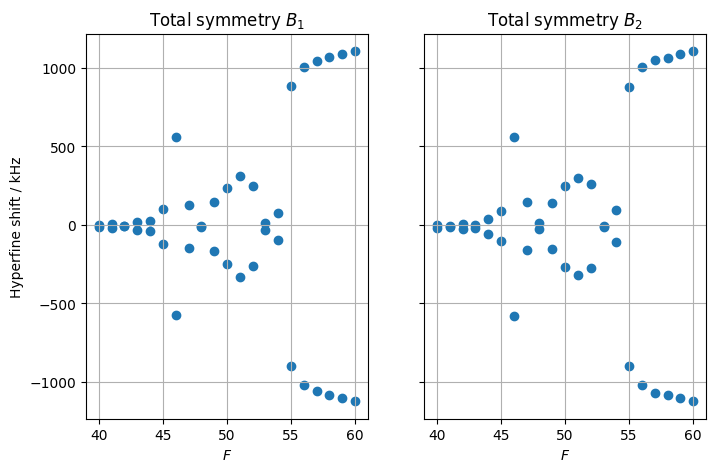

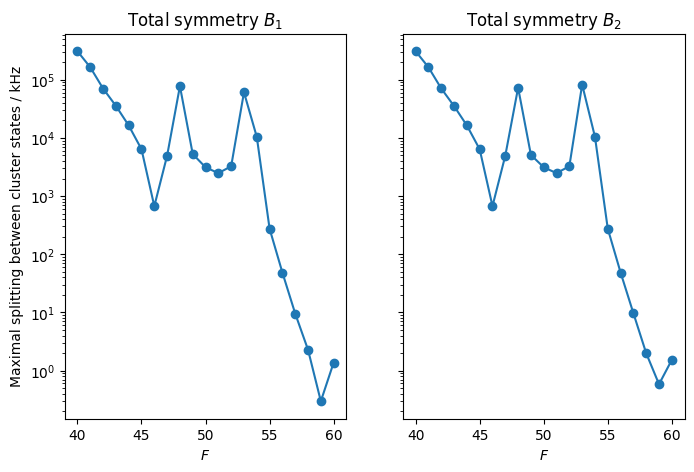

In [49]:
shift_f = {"B1": [], "B2": []}
split_f = {"B1": [], "B2": []}
for f, val_sym in hyper_state_ind.items():
    for sym, state_list in val_sym.items():
        rov_e = np.sort(np.array([e for (_, _, e) in state_list]))
        de = np.max(np.abs(rov_e - rov_e[0])) / KHZ_TO_INVCM
        split_f[sym].append((f, de))
        for id, shift, rov_e in state_list:
            shift_f[sym].append((f, shift))
shift_f = {key: np.array(val) for key, val in shift_f.items()}
split_f = {key: np.array(val) for key, val in split_f.items()}

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for a, sym in zip(ax, shift_f.keys()):
    a.scatter(shift_f[sym][:, 0], shift_f[sym][:, 1])

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
ax[1].grid()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for a, sym in zip(ax, shift_f.keys()):
    a.plot(split_f[sym][:, 0], split_f[sym][:, 1])
    a.scatter(split_f[sym][:, 0], split_f[sym][:, 1])
ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Maximal splitting between cluster states / kHz")
ax[0].set_yscale("log")

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
ax[1].set_yscale("log")
plt.show()

Plot rotational spin-density for selected cluster states

In [6]:
f = 58.0 # fix value of F and m_f
m_f = f

In [7]:
def psi_on_grid(j: int, vib_ind, rot_ind, coefs, alpha, beta, gamma):
    """Computes rovibrational function for selected states on grid of Euler angles"""
    rot_k, rot_m, rot_mu, k_list, jktau_list = symtop_on_grid_split_angles(
        j, alpha, beta, gamma
    )
    rot_k = rot_k[rot_ind]
    vib_ind_unique = list(set(vib_ind))
    v_ind = [np.where(vib_ind == ind)[0] for ind in vib_ind_unique]
    unique_vec = np.zeros((len(vib_ind), len(vib_ind_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1
    rot_kv = np.einsum(
        "i...,img,iv->mvg...", coefs, rot_k, unique_vec, optimize="optimal"
    )
    return rot_kv, rot_m, rot_mu, enr, vib_ind_unique


def monte_carlo_distr(npoints, alpha, beta, gamma, dens, xyz):
    """Monte-Carlo sampling of Cartesian coordiantes based on density `dens[alpha, beta, gamma]`"""
    fdens = RegularGridInterpolator((alpha, beta, gamma), dens)
    points = np.random.uniform(
        low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints, 3)
    )
    w = fdens(points)
    signs = np.sign(w)
    abs_w = np.abs(w) / np.max(np.abs(dens))
    eta = np.random.uniform(0.0, 1.0, size=len(w))
    ind = np.where(abs_w > eta)
    points = points[ind]
    signs = signs[ind]
    rotmat = Rotation.from_euler("ZYZ", points).as_matrix()
    xyz_sample = np.dot(rotmat, xyz)
    kernel = stats.gaussian_kde(xyz_sample.T)
    weights = kernel(xyz_sample.T)
    return xyz_sample, weights, signs

Specify grids for Euler angles and coordinates of atoms in the molecular frame.

In [8]:
# grid of Euler angles

npoints = 30
alpha = np.linspace(0, 2 * np.pi, npoints)
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)

# reference Cartesian coordinates of atoms (from h2s_rovib.ipynb [3])

atom_label = ("S", "H1", "H2")
atom_xyz = np.array(
    [
        [-5.48977100e-02, 0.00000000e00, 1.12725516e-12],
        [8.70782813e-01, 0.00000000e00, 9.63109860e-01],
        [8.70782813e-01, 0.00000000e00, -9.63109860e-01],
    ]
)
atom_xyz = atom_xyz / np.linalg.norm(atom_xyz, axis=-1)[:, None]
print(atom_xyz)

[[-1.00000000e+00  0.00000000e+00  2.05337374e-11]
 [ 6.70658210e-01  0.00000000e+00  7.41766517e-01]
 [ 6.70658210e-01  0.00000000e+00 -7.41766517e-01]]


Compute rotational probability density for selected hyperfine states.

In [9]:
vec_thresh = 1e-6

dens = {}  # dens[(sym1, sym2)]

# precompute wavefunctions and contract them with three-j symbols

psi_threej = {}  # psi_threej[sym]
nz_vec_ind = {}  # nz_vec_ind[sym]

for sym in hyper_state_ind[f].keys():

    # indices of rovibrational states with significant contributions
    # to selected hyperfine states
    nz_vec_ind[sym] = np.unique(
        np.hstack(
            [
                np.where(np.abs(hyper_vec[f][sym][:, i]) > vec_thresh)[0]
                for (i, *_) in hyper_state_ind[f][sym]
            ]
        )
    )

    print(
        f"Rovibrational wavefunctions for F = {f}, sym = {sym}, "
        + f"no. states = {len(nz_vec_ind[sym])}, state indices = {nz_vec_ind[sym]}"
    )

    p = f + m_f
    ip = int(p)
    assert abs(p - ip) < 1e-16, f"F + m_f: {f} + {m_f} = {p} is not an integer number"
    prefac = (-1) ** p * np.sqrt(2 * f + 1)

    psi = []

    for hy_state_ind in nz_vec_ind[sym]:
        rov_qua = hyper_qua[f][sym][hy_state_ind]
        j = int(rov_qua[0])
        rov_sym = rov_qua[1]
        i = int(rov_qua[2])
        rv_state_ind = int(rov_qua[4])

        mi = np.linspace(-i, i, int(2 * i) + 1)
        mj = np.arange(-j, j + 1)
        mij = np.concatenate(
            (
                mi[:, None, None].repeat(len(mj), axis=1),
                mj[None, :, None].repeat(len(mi), axis=0),
            ),
            axis=-1,
        ).reshape(-1, 2)
        n = len(mij)
        two_mi, two_mj = mij.T * 2

        threej = wigner3j(
            [int(f * 2)] * n,
            [i * 2] * n,
            [j * 2] * n,
            [-int(m_f * 2)] * n,
            two_mi.astype(int),
            two_mj.astype(int),
            ignore_invalid=True,
        ).reshape(len(mi), len(mj))

        rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
            j,
            rovib_vind[j][rov_sym],
            rovib_rind[j][rov_sym],
            rovib_coefs[j][rov_sym][:, rv_state_ind],
            alpha,
            beta,
            gamma,
        )
        rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        psi.append((rot_kv, rot_m, rot_mu, vib_ind, i))

    psi_threej[sym] = psi

# compute densities

for sym1, psi1 in psi_threej.items():
    for sym2, psi2 in psi_threej.items():

        print(f"Hyperfine densities for F = {f}, (sym1, sym2) = {(sym1, sym2)}")

        # compute density in the product basis of rovibrational and spin functions

        prim_dens = np.zeros(
            (len(psi1), len(psi2), npoints, npoints, npoints), dtype=np.complex128
        )

        for ibra, (rot_kv1, rot_m1, rot_mu1, vib_ind1, i1) in enumerate(psi1):
            for iket, (rot_kv2, rot_m2, rot_mu2, vib_ind2, i2) in enumerate(psi2):
                if i1 != i2:
                    continue
                vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
                vi1 = [vib_ind1.index(v) for v in vib_ind12]
                vi2 = [vib_ind2.index(v) for v in vib_ind12]
                diff = list(set(vib_ind1) - set(vib_ind2))
                assert len(diff) == 0, (
                    f"different lists of vibrational quanta for basis states (ibra, iket) = {(i1, i2)},"
                    + f"diff: {diff}"
                )

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vi1]),
                    rot_kv2[:, vi2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mjg->ijg", np.conj(rot_m1), rot_m2, optimize="optimal"
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                prim_dens[ibra, iket] = np.einsum(
                    "ijg,ija,ijb,b->abg",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )

        # transform density to basis of hyperfine states

        vec1 = np.array(
            [
                hyper_vec[f][sym1][nz_vec_ind[sym1], i]
                for (i, *_) in hyper_state_ind[f][sym1]
            ]
        )
        vec2 = np.array(
            [
                hyper_vec[f][sym2][nz_vec_ind[sym2], i]
                for (i, *_) in hyper_state_ind[f][sym2]
            ]
        )

        dens[(sym1, sym2)] = np.einsum(
            "ki,ij...,lj->kl...", np.conj(vec1), prim_dens, vec2, optimize="optimal"
        )

Rovibrational wavefunctions for F = 58.0, sym = B1, no. states = 2, state indices = [1472 2471]
Rovibrational wavefunctions for F = 58.0, sym = B2, no. states = 2, state indices = [1525 2523]
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B1', 'B1')
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B1', 'B2')
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B2', 'B1')
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B2', 'B2')


Plot rotational densities.

sym = B1
istate = 0, enr = 30760.28665925995


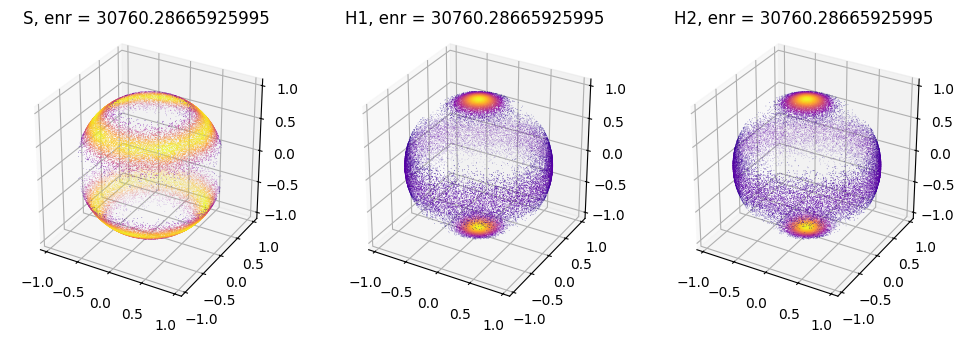

istate = 1, enr = 30760.286730999822


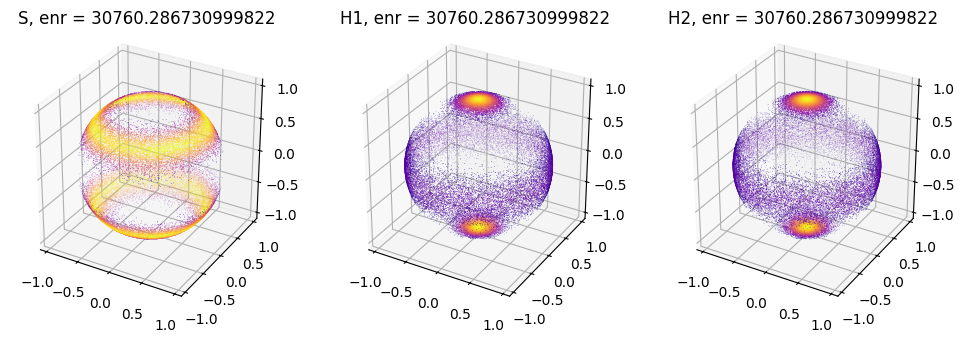

sym = B2
istate = 0, enr = 30760.286659268837


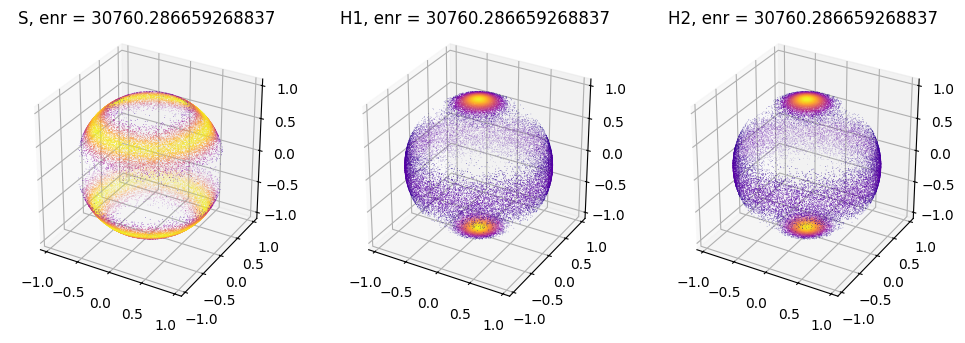

istate = 1, enr = 30760.286731009728


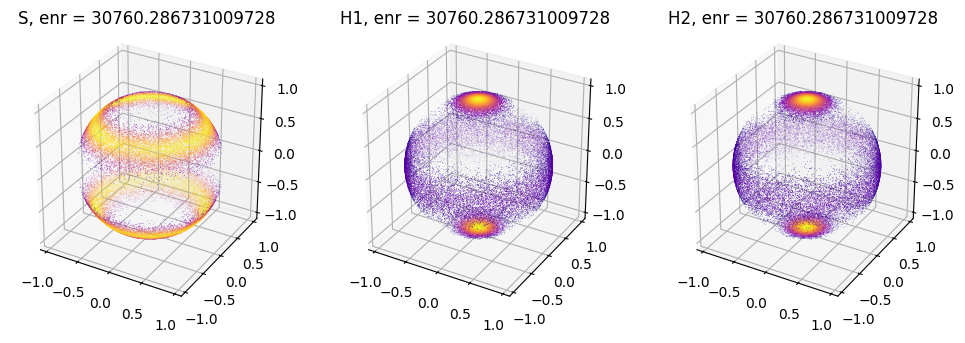

In [ ]:
for sym in ("B1", "B2"):
    print("sym =", sym)

    for istate in range(len(dens[sym, sym])):
        ind, *_ = hyper_state_ind[f][sym][istate]
        e = hyper_enr[f][sym][ind]
        print(f"istate = {istate}, enr = {e}")

        fig = plt.figure(figsize=(12, 12))
        axs = [
            fig.add_subplot(1, 3, 1, projection="3d"),
            fig.add_subplot(1, 3, 2, projection="3d"),
            fig.add_subplot(1, 3, 3, projection="3d"),
        ]
        for ax in axs:
            ax.set_box_aspect(aspect=(1, 1, 1))
            ax.axes.set_xlim3d(left=-1.1, right=1.1)
            ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
            ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

        for i, (xyz, ax) in enumerate(zip(atom_xyz, axs)):
            d = dens[(sym, sym)][istate, istate]
            xyz_samples, weights, signs = monte_carlo_distr(
                1000000, alpha, beta, gamma, d, xyz
            )

            ax.set_title(f"{atom_label[i]}, E = {np.round(e, 8)}")

            x, y, z = xyz_samples.T
            ax.scatter(
                x, y, z, c=weights, s=1, edgecolor="none", marker=".", cmap="plasma"
            )

        plt.show()

Compute rotational **spin-density** for selected hyperfine states.

In [11]:
vec_thresh = 1e-6

spin_dens = {}  # dens[(sym1, sym2)]

# precompute wavefunctions and contract them with three-j symbols

psi_threej = {}  # psi_threej[sym]
nz_vec_ind = {}  # nz_vec_ind[sym]

for sym in hyper_state_ind[f].keys():

    # indices of rovibrational states with significant contributions
    # to selected hyperfine states
    nz_vec_ind[sym] = np.unique(
        np.hstack(
            [
                np.where(np.abs(hyper_vec[f][sym][:, i]) > vec_thresh)[0]
                for (i, *_) in hyper_state_ind[f][sym]
            ]
        )
    )

    print(
        f"Rovibrational wavefunctions for F = {f}, sym = {sym}, "
        + f"no. states = {len(nz_vec_ind[sym])}, state indices = {nz_vec_ind[sym]}"
    )

    p = f + m_f
    ip = int(p)
    assert abs(p - ip) < 1e-16, f"F + m_f: {f} + {m_f} = {p} is not an integer number"
    prefac = (-1) ** p * np.sqrt(2 * f + 1)

    psi = []

    for hy_state_ind in nz_vec_ind[sym]:
        rov_qua = hyper_qua[f][sym][hy_state_ind]
        j = int(rov_qua[0])
        rov_sym = rov_qua[1]
        i = int(rov_qua[2])
        rv_state_ind = int(rov_qua[4])

        mi = np.linspace(-i, i, int(2 * i) + 1)
        mj = np.arange(-j, j + 1)
        mij = np.concatenate(
            (
                mi[:, None, None].repeat(len(mj), axis=1),
                mj[None, :, None].repeat(len(mi), axis=0),
            ),
            axis=-1,
        ).reshape(-1, 2)
        n = len(mij)
        two_mi, two_mj = mij.T * 2

        threej = wigner3j(
            [int(f * 2)] * n,
            [i * 2] * n,
            [j * 2] * n,
            [-int(m_f * 2)] * n,
            two_mi.astype(int),
            two_mj.astype(int),
            ignore_invalid=True,
        ).reshape(len(mi), len(mj))

        rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
            j,
            rovib_vind[j][rov_sym],
            rovib_rind[j][rov_sym],
            rovib_coefs[j][rov_sym][:, rv_state_ind],
            alpha,
            beta,
            gamma,
        )
        rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        psi.append((rot_kv, rot_m, rot_mu, vib_ind, i))

    psi_threej[sym] = psi

# compute densities

for sym1, psi1 in psi_threej.items():
    for sym2, psi2 in psi_threej.items():

        print(f"Hyperfine densities for F = {f}, (sym1, sym2) = {(sym1, sym2)}")

        # compute density in the product basis of rovibrational and spin functions

        prim_dens = np.zeros(
            (len(psi1), len(psi2), npoints, npoints, npoints, 3, 2), dtype=np.complex128
        )

        for ibra, (rot_kv1, rot_m1, rot_mu1, vib_ind1, i1) in enumerate(psi1):
            for iket, (rot_kv2, rot_m2, rot_mu2, vib_ind2, i2) in enumerate(psi2):
                vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
                vi1 = [vib_ind1.index(v) for v in vib_ind12]
                vi2 = [vib_ind2.index(v) for v in vib_ind12]
                diff = list(set(vib_ind1) - set(vib_ind2))
                assert len(diff) == 0, (
                    f"different lists of vibrational quanta for basis states (ibra, iket) = {(i1, i2)},"
                    + f"diff: {diff}"
                )

                spin_me = spin_me_xy2(i1, i2, SPIN1, SPIN2)

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vi1]),
                    rot_kv2[:, vi2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mn...,njg->ijg...",
                    np.conj(rot_m1),
                    spin_me,
                    rot_m2,
                    optimize="optimal",
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                prim_dens[ibra, iket] = np.einsum(
                    "ijg,ija...,ijb,b->abg...",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )

        # transform density to basis of hyperfine states

        vec1 = np.array(
            [
                hyper_vec[f][sym1][nz_vec_ind[sym1], i]
                for (i, *_) in hyper_state_ind[f][sym1]
            ]
        )
        vec2 = np.array(
            [
                hyper_vec[f][sym2][nz_vec_ind[sym2], i]
                for (i, *_) in hyper_state_ind[f][sym2]
            ]
        )

        spin_dens[(sym1, sym2)] = np.einsum(
            "ki,ij...,lj->kl...", np.conj(vec1), prim_dens, vec2, optimize="optimal"
        )

Rovibrational wavefunctions for F = 58.0, sym = B1, no. states = 2, state indices = [1472 2471]
Rovibrational wavefunctions for F = 58.0, sym = B2, no. states = 2, state indices = [1525 2523]
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B1', 'B1')
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B1', 'B2')
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B2', 'B1')
Hyperfine densities for F = 58.0, (sym1, sym2) = ('B2', 'B2')


Plot rotational **spin-densities**.

sym = B1
istate = 0, enr = 30760.28665925995


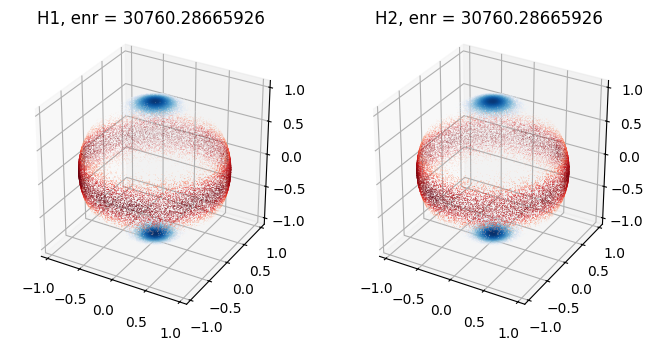

istate = 1, enr = 30760.286730999822


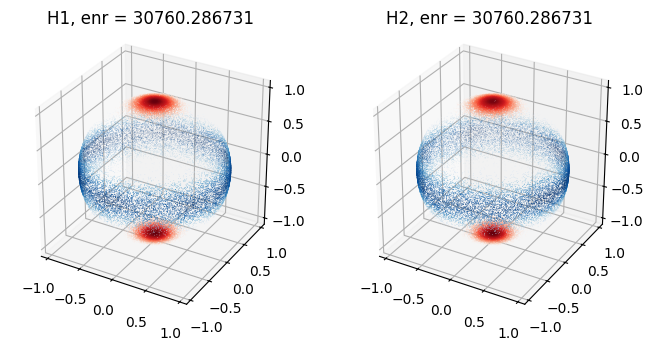

sym = B2
istate = 0, enr = 30760.286659268837


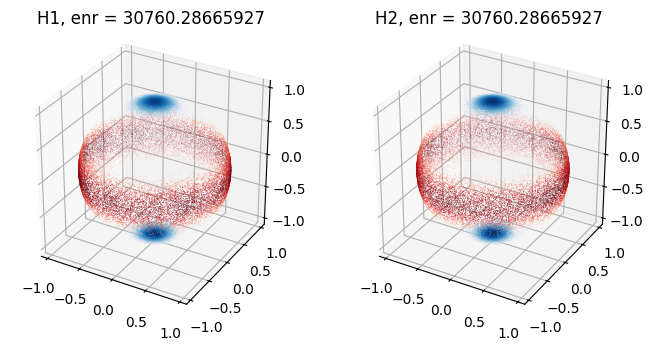

istate = 1, enr = 30760.286731009728


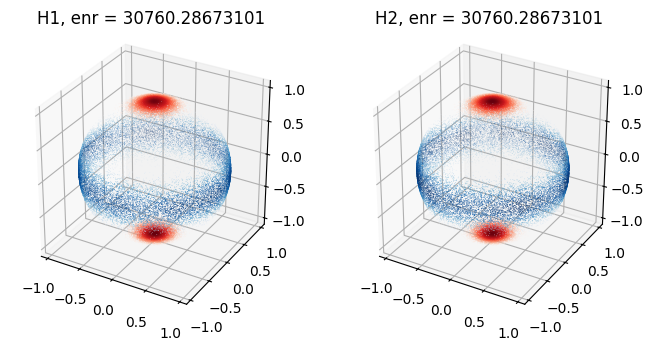

In [13]:
for sym in ("B1", "B2"):
    print("sym =", sym)

    for istate in range(len(dens[sym, sym])):
        ind, *_ = hyper_state_ind[f][sym][istate]
        e = hyper_enr[f][sym][ind]
        print(f"istate = {istate}, enr = {e}")

        fig = plt.figure(figsize=(8, 8))
        axs = [
            fig.add_subplot(1, 2, 1, projection="3d"),
            fig.add_subplot(1, 2, 2, projection="3d"),
        ]
        for ax in axs:
            ax.set_box_aspect(aspect=(1, 1, 1))
            ax.axes.set_xlim3d(left=-1.1, right=1.1)
            ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
            ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

        for i, (xyz, ax) in enumerate(zip(atom_xyz[1:], axs)):  # skip S atom
            dz = spin_dens[(sym, sym)][istate, istate, :, :, :, -1, i]
            xyz_samples, weights, signs = monte_carlo_distr(
                1000000, alpha, beta, gamma, dz, xyz
            )

            ax.set_title(f"{atom_label[i+1]}, E = {np.round(e, 8)}")

            pos_ind = np.where(signs > 0)
            neg_ind = np.where(signs < 0)

            ax.scatter(
                *xyz_samples[pos_ind].T,
                c=weights[pos_ind],
                s=1,
                edgecolor="none",
                marker=".",
                cmap="Reds",
            )
            ax.scatter(
                *xyz_samples[neg_ind].T,
                c=weights[neg_ind],
                s=1,
                edgecolor="none",
                marker=".",
                cmap="Blues",
            )

        plt.show()

-------

Compute hyperfine energies and wavefunctions, identify hyperfine states that belong to the cluster states.

Plot absolute values of hyperfine shifts for all cluster states as function of quantum number of total angular momentum $F$.

When examining the square of the coefficient for the leading basis function, it remains close to 0.9 for $J=50..54$.
In this range, the plot shows that the hyperfine shift for different symmetries alternates sign between even and odd $J$ values.
However, for $J\geq 55$, this behavior is not evident in the plots.
This is because the square of the coefficient for the leading function approaches $1/\sqrt{2}$ leading
to an ambiguous assignment of states based on rovibrational symmetry, as several states become strongly coupled.

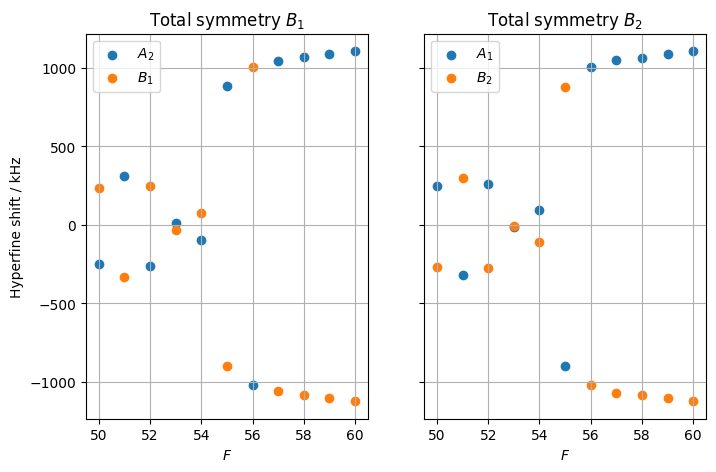

In [8]:
F_list = list(hyper_shift.keys())

shift_B1 = np.array(
    [
        sum([val for sym, val in hyper_shift[F].items() if sym == "B1"], [])
        for F in hyper_shift.keys()
    ]
)

shift_B2 = np.array(
    [
        sum([val for sym, val in hyper_shift[F].items() if sym == "B2"], [])
        for F in hyper_shift.keys()
    ]
)

rov_sym_B1 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym[F].items() if sym in ("A2", "B1")], [])
        for F in hyper_shift.keys()
    ]
)

rov_sym_B2 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym[F].items() if sym in ("A1", "B2")], [])
        for F in hyper_shift.keys()
    ]
)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for sym in ("A2", "B1"):
    ind = [np.where(rov_sym_B1[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B1[i, j] for i, j in enumerate(ind)]
    ax[0].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

for sym in ("A1", "B2"):
    ind = [np.where(rov_sym_B2[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B2[i, j] for i, j in enumerate(ind)]
    ax[1].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
# ax[1].set_ylabel("Hyperfine shift / kHz")
ax[1].grid()
ax[1].legend()
plt.show()

## Simplified calculation including only cluster states

We also compute hyperfine energies and wavefunctions including only rotational cluster states for selected rotational quantum number $J$ into the basis and neglect the coupling of states with $|\Delta J|>0$.

The results in the printout of hyperfine states and the plot of hyperfine shifts below are numerically identical to those calculated above considering all states.

Load the rovibrational energies and matrix elements of spin-rotation tensors and electric dipole moment, computed and stored in `h2s_cart_me.ipynb` notebook. Select only cluster states.

In [9]:
pmax = 20
min_J = 50
max_J = 60

print(f"Read state energies and assignments for J = {min_J}..{max_J}")

with h5py.File(f"h2s_enr_pmax{pmax}.h5", "r") as h5:
    enr_ = hdfdict.load(h5.require_group("energies"), False)
    qua_ = hdfdict.load(h5.require_group("quanta"), False)

enr_cluster = {
    J: {sym: enr_[str(J)][sym][id] for sym, id in id_J.items()}
    for J, id_J in cluster_state_id.items()
}

qua_cluster = {
    J: {
        sym: np.array(
            [
                [i] + list(elem[0].decode("utf-8").split(","))
                for elem, i in zip(qua_[str(J)][sym][id], id)
            ]
        )
        for sym, id in id_J.items()
    }
    for J, id_J in cluster_state_id.items()
}

for J in enr_cluster.keys():
    for sym in enr_cluster[J].keys():
        print(
            f"J = {J}, sym = {sym}, enr.shape = {enr_cluster[J][sym].shape}, "
            + f"qua.shape = {qua_cluster[J][sym].shape}"
        )

print(f"Read spin-rotation and dipole matrix elements for J = {min_J}..{max_J}")

sr1_cluster = {}
sr2_cluster = {}
dipole_cluster = {}

for J1, id_J1 in cluster_state_id.items():
    for J2, id_J2 in cluster_state_id.items():
        try:
            filename = f"h2s_me_pmax{pmax}_j{J1}_j{J2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(J1, J2)}, |dJ| = {abs(J1-J2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2 = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dip = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dip = {}

                oper_sym = [{}, {}, {}]
                for sym1, id1 in id_J1.items():
                    for sym2, id2 in id_J2.items():
                        nstates1 = len(enr_[str(J1)][sym1])
                        nstates2 = len(enr_[str(J2)][sym2])
                        for i, oper in enumerate((sr1, sr2, dip)):
                            if sym1 in oper and sym2 in oper[sym1]:
                                me = oper[sym1][sym2]
                                oper_sym[i][(sym1, sym2)] = (
                                    csr_matrix(
                                        (me["data"], me["indices"], me["indptr"]),
                                        shape=me["shape"],
                                    )
                                    .toarray()
                                    .reshape(nstates1, nstates2, -1)[np.ix_(id1, id2)]
                                )
                sr1_cluster[(J1, J2)] = oper_sym[0]
                sr2_cluster[(J1, J2)] = oper_sym[1]
                dipole_cluster[(J1, J2)] = oper_sym[2]
        except FileNotFoundError:
            pass

Read state energies and assignments for J = 50..60
J = 50, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 54, sym = B2, enr.shape = (1,), qua.shape = (1, 1

Compute hyperfine energies and wavefunctions

In [10]:
min_F = 50
max_F = 60

hyper_enr_cluster = {}
hyper_vec_cluster = {}
hyper_qua_cluster = {}
hyper_qua_block_cluster = {}

hyper_shift_cluster = {}
hyper_rov_sym_cluster = {}

for F in range(min_F, max_F + 1):

    J = F

    # comupute hyperfine spin-rotation energies and wavefunctions

    (
        hyper_enr_cluster[F],
        hyper_vec_cluster[F],
        hyper_qua_cluster[F],
        hyper_qua_block_cluster[F],
    ) = spinrot_xy2(
        F,
        {J: enr_cluster[J]},
        {J: qua_cluster[J]},
        {(J, J): sr1_cluster[(J, J)]},
        {(J, J): sr2_cluster[(J, J)]},
        spin_states=((0, "B2"), (1, "A1")),
        spins=(0.5, 0.5),
    )

    # print assignments of hypefine cluster states

    hyper_shift_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    hyper_rov_sym_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    for sym in hyper_enr_cluster[F].keys():
        for i in range(len(hyper_enr_cluster[F][sym])):
            ind = np.argmax(hyper_vec_cluster[F][sym][:, i] ** 2, axis=0)
            rov_ind = int(hyper_qua_cluster[F][sym][ind][4])
            rov_sym = hyper_qua_cluster[F][sym][ind][1]
            j = int(hyper_qua_cluster[F][sym][ind][0])
            rov_enr = enr_[str(j)][rov_sym][rov_ind]
            hyper_shift_cluster[F][sym].append(
                (hyper_enr_cluster[F][sym][i] - rov_enr) / KHZ_TO_INVCM
            )
            hyper_rov_sym_cluster[F][sym].append(rov_sym)
            print(
                f"F = {F}, sym = {sym}, enr = {hyper_enr_cluster[F][sym][i]}, shift (kHz) = {hyper_shift_cluster[F][sym][-1]}, "
                + f"leading quanta = {hyper_qua_cluster[F][sym][ind]}, max(c**2) = {hyper_vec_cluster[F][sym][ind, i]**2}"
            )

F = 50, sym = B1, enr = 24708.81878741142, shift (kHz) = -251.3131280131165, leading quanta = ['50' 'A2' '0' 'B2' '242' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B1, enr = 24708.81890790879, shift (kHz) = 235.51446431863732, leading quanta = ['50' 'B1' '1' 'A1' '242' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B2, enr = 24708.818786957007, shift (kHz) = -264.91295520853527, leading quanta = ['50' 'B2' '1' 'A1' '277' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1'], max(c**2) = (0.9315598651704518-0j)
F = 50, sym = B2, enr = 24708.818908370573, shift (kHz) = 249.1142915140561, leading quanta = ['50' 'A1' '0' 'B2' '280' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2'], max(c**2) = (0.9315598651704518+0j)
F = 51, sym = B1, enr = 25447.364236702117, shift (kHz) = -329.4375347059373, leading quanta = ['51' 'B1' '1' 'A1' '299' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1'], max(c**2) = (0.8995880069142649-0j)
F = 

Plot absolute values of hyperfine shifts for all cluster states as function of quantum number of total angular momentum $F$.

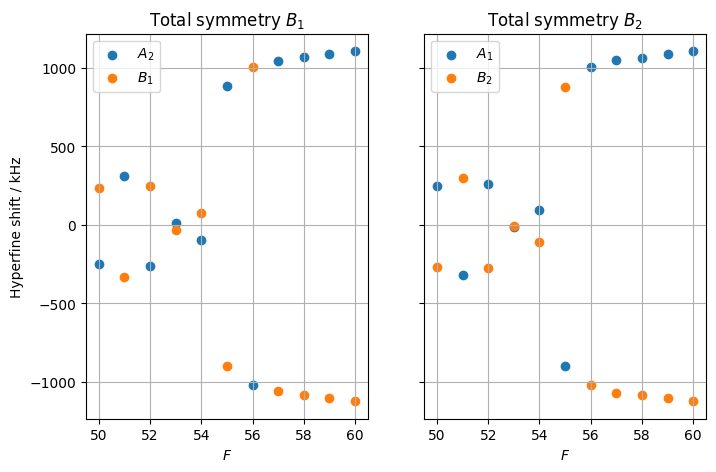

In [11]:
F_list = list(hyper_shift_cluster.keys())

shift_B1 = np.array(
    [
        sum([val for sym, val in hyper_shift_cluster[F].items() if sym == "B1"], [])
        for F in hyper_shift_cluster.keys()
    ]
)

shift_B2 = np.array(
    [
        sum([val for sym, val in hyper_shift_cluster[F].items() if sym == "B2"], [])
        for F in hyper_shift_cluster.keys()
    ]
)

rov_sym_B1 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym_cluster[F].items() if sym in ("A2", "B1")], [])
        for F in hyper_shift_cluster.keys()
    ]
)

rov_sym_B2 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym_cluster[F].items() if sym in ("A1", "B2")], [])
        for F in hyper_shift_cluster.keys()
    ]
)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for sym in ("A2", "B1"):
    ind = [np.where(rov_sym_B1[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B1[i, j] for i, j in enumerate(ind)]
    ax[0].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

for sym in ("A1", "B2"):
    ind = [np.where(rov_sym_B2[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B2[i, j] for i, j in enumerate(ind)]
    ax[1].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
# ax[1].set_ylabel("Hyperfine shift / kHz")
ax[1].grid()
ax[1].legend()
plt.show()

## Stark effect

Simulate the effect of static external electric field on hyperfine states. The field is polarized along the laboratory $Z$ axis.

In [37]:
m_f = 60

# matrix elements of dipole moment operator in hyperfine basis

dip_me, dip_qua = dipole_xy2(hyper_qua_block, hyper_vec, dipole, m_val=m_f)

# # field-free Hamiltonian (hyperfine energies)

h0 = np.diag(
    np.concatenate(
        [
            hyper_enr[f][sym]
            for f in hyper_qua_block.keys()
            for sym in hyper_qua_block[f].keys()
            if f >= abs(m_f)
        ],
        axis=0,
    )
)

print("basis set size:", h0.shape[-1])

# compute Stark effect for field along Z

field = np.linspace(0, 1000, 2)  # in V/m
stark_enr = []
stark_vec = []
for fz in field:
    print(f"Stark effect for Fz = {fz}")
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    stark_enr.append(e)
    stark_vec.append(v)
stark_enr = np.array(stark_enr)
stark_vec = np.array(stark_vec)

basis set size: 6000
Stark effect for Fz = 0.0
Stark effect for Fz = 1000.0


In [44]:
# determine cluster states

field_ind = 1
ind = [np.argmax(np.abs(v) ** 2, axis=0) for v in stark_vec]

for bas_ind, (f, m, sym, hyper_ind) in enumerate(dip_qua):
    if int(hyper_ind) in hyper_id[float(f)][sym]:
        state_ind = [np.where(i == bas_ind)[0].tolist() for i in ind]
        c2 = [np.abs(v[bas_ind, i]) ** 2 for i, v in zip(state_ind, stark_vec)]
        en = [e[i] for i, e in zip(state_ind, stark_enr)]
        print(f, m, sym, bas_ind, state_ind, c2, en)

60 60 B1 1792 [[3632], [3632]] [array([1.]), array([0.50001045])] [array([32309.80414675]), array([32309.8040555])]
60 60 B1 1793 [[3634], [3633]] [array([1.]), array([0.50000947])] [array([32309.80422107]), array([32309.80412982])]
60 60 B2 4840 [[3633], [3634]] [array([1.]), array([0.5000104])] [array([32309.80414676]), array([32309.80423801])]
60 60 B2 4841 [[3635], [3635]] [array([1.]), array([0.50000952])] [array([32309.80422108]), array([32309.80431233])]


In [88]:
f = 60
sym = 'B1'

ind = np.argmax(np.abs(hyper_vec[f][sym]) ** 2, axis=0)

for bas_ind, (j, rov_sym, i, spin_sym, rov_id, *_) in enumerate(hyper_qua[f][sym]):
    if int(rov_id) in cluster_state_id[int(j)][rov_sym]:
        state_ind = np.where(ind == bas_ind)
        print(f, j, rov_sym, rov_id, bas_ind, state_ind, hyper_enr[f][sym][state_ind])

60 59 B1 565 565 (array([1414]),) [31533.97097627]
60 60 A2 544 1544 (array([1793]),) [32309.80422107]
60 60 B1 542 2542 (array([1792]),) [32309.80414675]


In [81]:
enr

array([[19566.59558965, 20080.20354216, 20087.93995461, ...,
        34483.86751968, 34483.87757076, 34485.36251105],
       [19566.59558965, 20080.20354216, 20087.93995461, ...,
        34483.86751968, 34483.87757076, 34485.36251105]])

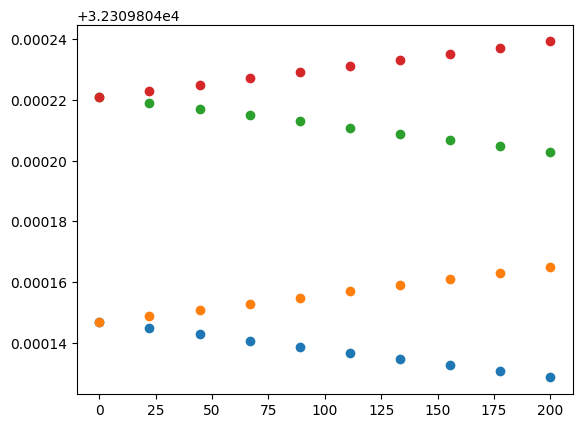

In [40]:
F = 60
m_F = F

# matrix elements of dipole moment operator in hyperfine basis
dip_me, dip_qua, dip_qua_block = dipole_xy2(
    {F: hyper_qua_block_cluster[F]},
    {F: hyper_vec_cluster[F]},
    qua_cluster,
    dipole_cluster,
    m_val=m_F,
)

# field-free Hamiltonian (hyperfine energies)
h0 = np.diag(
    np.concatenate(
        [enr_sym for sym, enr_sym in hyper_enr_cluster[F].items()],
        axis=0,
    )
)

# compute Stark effect for field along Z
field = np.linspace(0, 200, 10) # in V/m
enr = []
vec = []
for fz in field:
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    enr.append(e)
    vec.append(v)
enr = np.array(enr)
vec = np.array(vec)

for e in enr.T:
    plt.scatter(field, e)

Store solutions for $F_Z=0$ and 200 V/cm in file

In [14]:
with h5py.File(f"h2s_hyperfine_clusters_f{F}.h5", "w") as h5:
    h5.create_dataset("field", data=field)
    h5.create_dataset("energies", data=enr)
    h5.create_dataset("coefficients", data=vec)
    qua_str = [",".join(elem) for elem in dip_qua]
    max_len = max([len(elem) for elem in qua_str])
    qua_ascii = [elem.encode("ascii", "ignore") for elem in qua_str]
    h5.create_dataset(sym, (len(qua_ascii), 1), f"S{max_len}", data=qua_ascii)

In [41]:
print(enr)

[[32309.80414675 32309.80414676 32309.80422107 32309.80422108]
 [32309.80414473 32309.80414878 32309.80421905 32309.8042231 ]
 [32309.8041427  32309.80415081 32309.80421702 32309.80422513]
 [32309.80414067 32309.80415284 32309.80421499 32309.80422716]
 [32309.80413864 32309.80415487 32309.80421296 32309.80422919]
 [32309.80413662 32309.8041569  32309.80421093 32309.80423121]
 [32309.80413459 32309.80415892 32309.80420891 32309.80423324]
 [32309.80413256 32309.80416095 32309.80420688 32309.80423527]
 [32309.80413053 32309.80416298 32309.80420485 32309.8042373 ]
 [32309.8041285  32309.80416501 32309.80420282 32309.80423933]]


## Nuclear-spin density

In [29]:
def psi_on_grid(
    J: int,
    sym: str,
    state_ind: int,
    alpha,
    beta,
    gamma,
    pmax: int = 20,
):
    """Computes rovibrational function for selected state on grid of Euler angles"""

    rot_k, rot_m, rot_mu, k_list, jktau_list = symtop_on_grid_split_angles(
        J, alpha, beta, gamma
    )

    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{J}.h5", "r")
    enr = h5["energies"][sym][state_ind]
    coefs = h5["coefficients"][sym][:, state_ind]
    qua = np.array(
        [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
    )
    vib_qua = qua[:, 2:6]
    rot_qua = qua[:, 6:9]

    # compute rotational part for all basis functions
    ktau_ind = [
        np.where(
            (jktau_list[:, 0] == str(J))
            & (jktau_list[:, 1] == k)
            & (jktau_list[:, 2] == tau)
        )[0][0]
        for (k, tau) in rot_qua[:, :2]
    ]
    rot_k = rot_k[ktau_ind]  # shape = (ktau, mu, point)

    # unique set of vibrational quanta
    vib_qua_unique = list(set([tuple(elem) for elem in vib_qua]))
    v_ind = [
        np.where(
            (vib_qua[:, 0] == v1)
            & (vib_qua[:, 1] == v2)
            & (vib_qua[:, 2] == v3)
            & (vib_qua[:, 3] == vsym)
        )[0]
        for (v1, v2, v3, vsym) in vib_qua_unique
    ]
    unique_vec = np.zeros((len(qua), len(vib_qua_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1

    rot_kv = np.einsum("i,img,iv->mvg", coefs, rot_k, unique_vec, optimize="optimal")

    return rot_kv, rot_m, rot_mu, enr, vib_qua_unique

In [30]:
def monte_carlo_distr(npoints, alpha, beta, gamma, dens, xyz):
    fdens = RegularGridInterpolator((alpha, beta, gamma), dens)
    points = np.random.uniform(
        low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints, 3)
    )
    w = fdens(points)
    signs = np.sign(w)
    abs_w = np.abs(w) / np.max(np.abs(dens))
    eta = np.random.uniform(0.0, 1.0, size=len(w))
    ind = np.where(abs_w > eta)
    points = points[ind]
    signs = signs[ind]
    rotmat = Rotation.from_euler("ZYZ", points).as_matrix()
    xyz_sample = np.dot(rotmat, xyz)
    kernel = stats.gaussian_kde(xyz_sample.T)
    weights = kernel(xyz_sample.T)
    return xyz_sample, weights, signs

In [31]:
npoints = 30
alpha = np.linspace(0, 2 * np.pi, npoints)
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
euler_grid = np.array([elem for elem in itertools.product(alpha, beta, gamma)])

In [32]:
atom_xyz = np.array(
    [
        [8.82173006e-01, 0.00000000e00, 9.71108730e-01],
        [8.82173006e-01, 0.00000000e00, -9.71108730e-01],
    ]
)
atom_xyz = atom_xyz / np.linalg.norm(atom_xyz, axis=-1)[:, None]

In [33]:
rot_kv, rot_m, rot_mu, enr, vib_qua = psi_on_grid(50, "A1", 280, alpha, beta, gamma)

den_kv = np.einsum("ivg,jvg->ijg", np.conj(rot_kv), rot_kv, optimize="optimal")
den_m = np.einsum("mig,mjg->mijg", np.conj(rot_m), rot_m, optimize="optimal")
den_mu = np.einsum("ig,jg->ijg", np.conj(rot_mu), rot_mu, optimize="optimal")
dens = np.einsum(
    "ijg,ija,ijb->abg", den_kv, den_m[-1], den_mu, optimize="optimal"
) * np.sin(beta[None, :, None])
dens = np.abs(dens)

atom 0


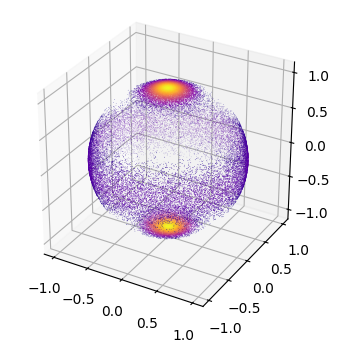

atom 1


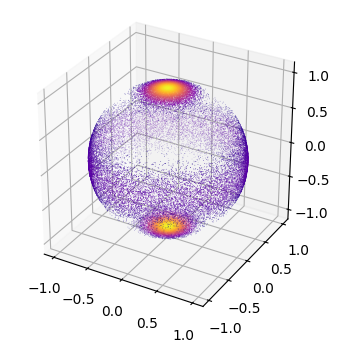

In [34]:
for i, xyz in enumerate(atom_xyz):
    print(f"atom {i}")
    xyz_samples, weights, signs = monte_carlo_distr(
        1000000, alpha, beta, gamma, dens, xyz
    )

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection="3d")
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.axes.set_xlim3d(left=-1.1, right=1.1)
    ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
    ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

    ax.scatter(
        *xyz_samples.T, c=weights, s=1, edgecolor="none", marker=".", cmap="plasma"
    )
    plt.show()

compute densities for F = 60, sym = B1
0 ['60' 'B1' '1' 'A1' '542' 'B1' '60' '0' '2' '1' 'B2' '5' '1' 'A2']
1 ['60' 'A2' '0' 'B2' '544' 'A2' '60' '0' '2' '1' 'B2' '10' '1' 'B1']
0 0 (2, 2, 30, 30, 30, 3, 2)
0 1 (2, 2, 30, 30, 30, 3, 2)
1 0 (2, 2, 30, 30, 30, 3, 2)
1 1 (2, 2, 30, 30, 30, 3, 2)
state index: 0


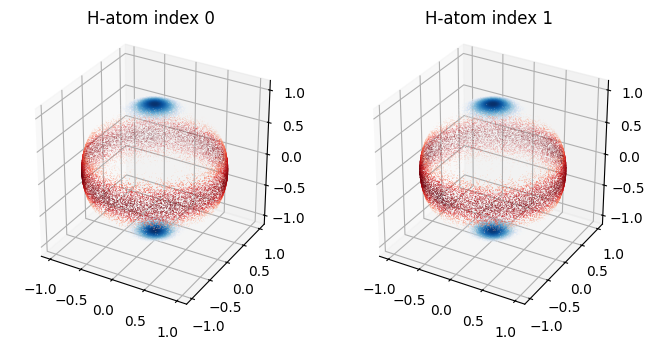

state index: 1


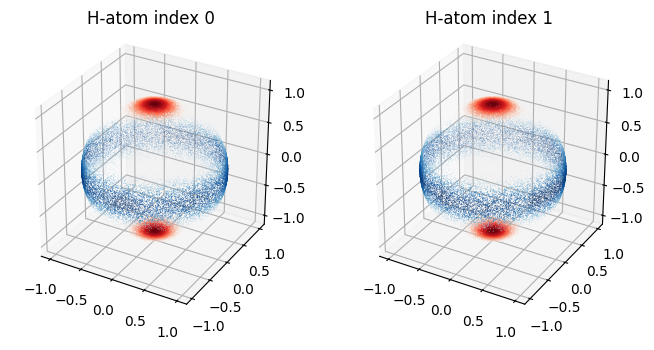

compute densities for F = 60, sym = B2
0 ['60' 'A1' '0' 'B2' '600' 'A1' '60' '1' '1' '1' 'A1' '34' '0' 'A1']
1 ['60' 'B2' '1' 'A1' '599' 'B2' '60' '1' '1' '1' 'A1' '47' '0' 'B2']
0 0 (2, 2, 30, 30, 30, 3, 2)
0 1 (2, 2, 30, 30, 30, 3, 2)
1 0 (2, 2, 30, 30, 30, 3, 2)
1 1 (2, 2, 30, 30, 30, 3, 2)
state index: 0


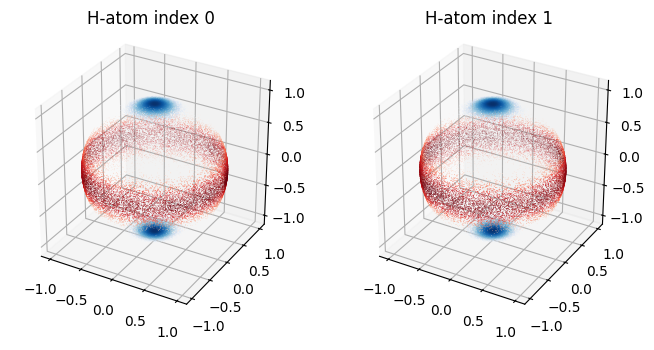

state index: 1


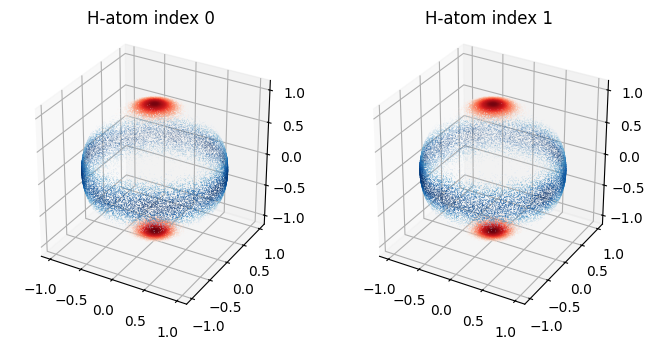

In [35]:
for F in hyper_qua_cluster.keys():

    if F != 60:
        continue

    mF = F

    for sym in hyper_qua_cluster[F].keys():

        print(f"compute densities for F = {F}, sym = {sym}")

        psi_threej = []

        p = F + mF
        ip = int(p)
        assert abs(p - ip) < 1e-16, f"F + mF: {F} + {mF} = {p} is not an integer number"
        prefac = (-1) ** p * np.sqrt(2 * F + 1)

        for i, qua in enumerate(hyper_qua_cluster[F][sym]):
            rov_state_ind = int(qua[4])
            rov_sym = qua[1]
            J = int(qua[0])
            I = int(qua[2])
            print(i, qua)

            two_mI, two_mJ = np.array(
                [
                    (int(mI * 2), int(mJ * 2))
                    for mI in np.linspace(-I, I, int(2 * I) + 1)
                    for mJ in range(-J, J + 1)
                ]
            ).T
            nelem = len(two_mI)
            threej = wigner3j(
                [F * 2] * nelem,
                [I * 2] * nelem,
                [J * 2] * nelem,
                [-mF * 2] * nelem,
                two_mI,
                two_mJ,
                ignore_invalid=True,
            ).reshape(2 * I + 1, 2 * J + 1)

            rot_kv, rot_m, rot_mu, enr, vib_qua = psi_on_grid(
                J, rov_sym, rov_state_ind, alpha, beta, gamma
            )
            rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
            psi_threej.append((rot_kv, rot_m, rot_mu, vib_qua, I))

        n = len(psi_threej)
        dens = np.zeros((n, n, npoints, npoints, npoints, 3, 2), dtype=np.complex128)
        for i1, (rot_kv1, rot_m1, rot_mu1, vib_qua1, I1) in enumerate(psi_threej):
            for i2, (rot_kv2, rot_m2, rot_mu2, vib_qua2, I2) in enumerate(psi_threej):
                vib_qua12 = list(set(vib_qua1) & set(vib_qua2))
                vib_ind1 = [vib_qua1.index(v) for v in vib_qua12]
                vib_ind2 = [vib_qua2.index(v) for v in vib_qua12]
                diff = list(set(vib_qua1) - set(vib_qua2))
                assert len(diff) == 0, (
                    f"different lists of vib quanta for basis states (i1, i2) = {(i1, i2)},"
                    + f"diff: {diff}"
                )

                spin_me = spin_me_xy2(I1, I2, 0.5, 0.5)

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vib_ind1]),
                    rot_kv2[:, vib_ind2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mn...,njg->ijg...",
                    np.conj(rot_m1),
                    spin_me,
                    rot_m2,
                    optimize="optimal",
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                dens[i1, i2] = np.einsum(
                    "ijg,ija...,ijb,b->abg...",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )
                print(i1, i2, dens.shape)

        dens = np.real(
            np.einsum(
                "ik,ij...,jk->k...",
                np.conj(hyper_vec_cluster[F][sym]),
                dens,
                hyper_vec_cluster[F][sym],
                optimize="optimal",
            )
        )

        for istate in range(2):
            print("state index:", istate)

            fig = plt.figure(figsize=(8, 8))
            axs = [
                fig.add_subplot(1, 2, 1, projection="3d"),
                fig.add_subplot(1, 2, 2, projection="3d"),
            ]
            for ax in axs:
                ax.set_box_aspect(aspect=(1, 1, 1))
                ax.axes.set_xlim3d(left=-1.1, right=1.1)
                ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
                ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

            for i, (xyz, ax) in enumerate(zip(atom_xyz, axs)):
                d = dens[istate, :, :, :, -1, i]
                xyz_samples, weights, signs = monte_carlo_distr(
                    1000000, alpha, beta, gamma, d, xyz
                )

                pos_ind = np.where(signs > 0)
                neg_ind = np.where(signs < 0)
                ax.set_title(f"H-atom index {i}")
                ax.scatter(
                    *xyz_samples[pos_ind].T,
                    c=weights[pos_ind],
                    s=1,
                    edgecolor="none",
                    marker=".",
                    cmap="Reds",
                )
                ax.scatter(
                    *xyz_samples[neg_ind].T,
                    c=weights[neg_ind],
                    s=1,
                    edgecolor="none",
                    marker=".",
                    cmap="Blues",
                )

            plt.show()